Original paper presented by Xinrui Wang and Jinze Yu. Find it [here](https://openaccess.thecvf.com/content_CVPR_2020/html/Wang_Learning_to_Cartoonize_Using_White-Box_Cartoon_Representations_CVPR_2020_paper.html)


In [1]:
#cloning the github repo of the original implementation of White-box-Cartoonization by Xinrui Wang and Jinze Yu.
!git clone --branch inference-tf-2.x https://github.com/steubk/White-box-Cartoonization.git

Cloning into 'White-box-Cartoonization'...
Updating files:  87% (42/48)
Updating files:  89% (43/48)
Updating files:  91% (44/48)
Updating files:  93% (45/48)
Updating files:  95% (46/48)
Updating files:  97% (47/48)
Updating files: 100% (48/48)
Updating files: 100% (48/48), done.


In [ ]:
#installing tf_slim library and tensorflowjs
!pip install --upgrade tf_slim
!pip install tensorflowjs --quiet

In [ ]:
import sys
sys.path.append('./White-box-Cartoonization/test_code')

import os
import matplotlib.pyplot as plt
import cartoonize

from PIL import Image

In [ ]:
#creating a directory to upload
!mkdir -p ./input

In [5]:
#Uploading images for conversion
%cd /content/input
from google.colab import files
uploaded = files.upload()

/content/input


Saving biryani.jpg to biryani.jpg
Saving charminar.jpg to charminar.jpg
Saving dhoni.jpg to dhoni.jpg
Saving rock.jpg to rock.jpg


In [6]:
%cd ../

/content


In [7]:
#model tests
import os

model_path = './White-box-Cartoonization/test_code/saved_models'
load_folder = './input'
save_folder = './output'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    
cartoonize.cartoonize(load_folder, save_folder, model_path)

Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Restoring parameters from ./White-box-Cartoonization/test_code/saved_models/model-33999


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


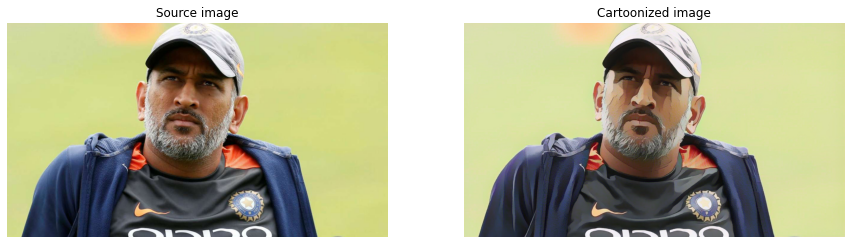

In [9]:
source_image = plt.imread('./input/dhoni.jpg')
cartoonized_image = plt.imread('./output/dhoni.jpg')

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(source_image)
ax[0].set_title('Source image')
ax[1].imshow(cartoonized_image)
ax[1].set_title('Cartoonized image')
[x.set_axis_off() for x in ax]
plt.show()

In [10]:
#create a directory to upload the video
!mkdir -p ./video_input
!mkdir -p ./video_output

In [11]:
#Upload video to convert them to cartoon
from google.colab import files
uploaded = files.upload()

Saving 292b11602f.mp4 to 292b11602f.mp4


In [12]:
# Opening the video file
import cv2
cap= cv2.VideoCapture('/content/292b11602f.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('/content/video_input/sample'+str(i)+'.jpg',frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

In [13]:
%cd /content

/content


In [14]:
#testing with sample data
import os
model_path = './White-box-Cartoonization/test_code/saved_models'
load_folder = './video_input'
save_folder = './video_output'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    
cartoonize.cartoonize(load_folder, save_folder, model_path)

INFO:tensorflow:Restoring parameters from ./White-box-Cartoonization/test_code/saved_models/model-33999


100%|██████████| 920/920 [02:13<00:00,  6.90it/s]


In [15]:
import cv2
import numpy as np
import os
 
from os.path import isfile, join
 
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    os.chdir("/content/video_output/") 
      
    images = [img for img in os.listdir('.') 
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")] 
 
    #sorting the file names properly
    files = sorted(images)
 
    for i in range(len(files)):
        filename=pathIn +"/" + files[i]
        #reading each file
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        #inserting the frames in an array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(frame_array)):
        # writing on an array of images
        out.write(frame_array[i])
    out.release()
 
def main():
    pathIn= '/content/video_output'
    pathOut = '/content/video2.avi'
    fps = 25.0
    convert_frames_to_video(pathIn, pathOut, fps)
 
if __name__=="__main__":
    main()

In [16]:
# saving the model
!mkdir -p models/CartoonGAN/saved_model

In [17]:
%cd /content/White-box-Cartoonization/test_code

/content/White-box-Cartoonization/test_code


In [18]:
# instantiating the model
import network
import guided_filter

In [19]:
# We will be using TensorFlow session
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [20]:
tf.__version__

'2.3.0'

In [21]:
%cd /content

/content


In [22]:
tf.reset_default_graph()
  
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
  # create placeholders
  input_photo = tf.placeholder(tf.float32, [1, None, None, 3], name='input_photo')
  
  # runing the input placeholder through the generator and then applying a filter to process the generator output
  network_out = network.unet_generator(input_photo)
  final_out = guided_filter.guided_filter(input_photo, network_out, r=1, eps=5e-3)
  final_out = tf.identity(final_out, name='final_output')
  
  # create an identical filtering layer 
 
  # get the generator variables and restore the pre-trained checkpoints 
  all_vars = tf.trainable_variables()
  gene_vars = [var for var in all_vars if 'generator' in var.name]
  saver = tf.train.Saver(var_list=gene_vars)
  sess.run(tf.global_variables_initializer())
  saver.restore(sess, tf.train.latest_checkpoint(model_path))
  
  # export to savedmodel
  tf.saved_model.simple_save(
      sess,
      '/content/models/CartoonGAN/saved_model',
      inputs={input_photo.name: input_photo},
      outputs={final_out.name: final_out})

INFO:tensorflow:Restoring parameters from ./White-box-Cartoonization/test_code/saved_models/model-33999
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /content/models/CartoonGAN/saved_model/saved_model.pb


In [23]:
ls -lah models/CartoonGAN/saved_model

total 152K
drwxr-xr-x 3 root root 4.0K Oct 15 12:39 ./
drwxr-xr-x 3 root root 4.0K Oct 15 12:39 ../
-rw-r--r-- 1 root root 137K Oct 15 12:39 saved_model.pb
drwxr-xr-x 2 root root 4.0K Oct 15 12:39 variables/


## TensorFlow.js conversion

In [24]:
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='final_output' \
    models/CartoonGAN/saved_model models/CartoonGAN/web

2020-10-15 12:40:14.685774: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-15 12:40:16.154365: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-15 12:40:16.159975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-15 12:40:16.160392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-10-15 12:40:16.160433: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-15 12:40:16.162200: I tensorflow/stream_executor/platform/default

**Quantize the weights (Float 16)**

In [25]:
!tensorflowjs_converter --quantize_float16 \
    --input_format=tf_saved_model --output_node_names='final_output' \
    models/CartoonGAN/saved_model models/CartoonGAN/web-float16

2020-10-15 12:41:42.843052: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-15 12:41:44.256731: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-15 12:41:44.261526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-15 12:41:44.261991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-10-15 12:41:44.262029: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-15 12:41:44.263825: I tensorflow/stream_executor/platform/default

**Quantize the weights (unit 8)**

In [26]:
!tensorflowjs_converter --quantize_uint8 \
    --input_format=tf_saved_model --output_node_names='final_output' \
    models/CartoonGAN/saved_model models/CartoonGAN/web-uint8

2020-10-15 12:41:50.316945: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-15 12:41:51.705118: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-15 12:41:51.709783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-15 12:41:51.710235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-10-15 12:41:51.710278: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-15 12:41:51.711800: I tensorflow/stream_executor/platform/default

Check model sizes

In [27]:
!du -sh models/CartoonGAN/*

5.8M	models/CartoonGAN/saved_model
5.7M	models/CartoonGAN/web
2.9M	models/CartoonGAN/web-float16
1.5M	models/CartoonGAN/web-uint8


Download models

In [28]:
!zip -r models.zip models

  adding: models/ (stored 0%)
  adding: models/CartoonGAN/ (stored 0%)
  adding: models/CartoonGAN/web/ (stored 0%)
  adding: models/CartoonGAN/web/group1-shard1of2.bin (deflated 7%)
  adding: models/CartoonGAN/web/group1-shard2of2.bin (deflated 7%)
  adding: models/CartoonGAN/web/model.json (deflated 93%)
  adding: models/CartoonGAN/web-float16/ (stored 0%)
  adding: models/CartoonGAN/web-float16/group1-shard1of1.bin (deflated 8%)
  adding: models/CartoonGAN/web-float16/model.json (deflated 93%)
  adding: models/CartoonGAN/saved_model/ (stored 0%)
  adding: models/CartoonGAN/saved_model/saved_model.pb (deflated 91%)
  adding: models/CartoonGAN/saved_model/variables/ (stored 0%)
  adding: models/CartoonGAN/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: models/CartoonGAN/saved_model/variables/variables.index (deflated 57%)
  adding: models/CartoonGAN/web-uint8/ (stored 0%)
  adding: models/CartoonGAN/web-uint8/group1-shard1of1.bin (deflated 16%)
  adding: mo

In [29]:
from google.colab import files
files.download('models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>